# Dependencies

In [68]:
# Standard library imports
import os
import logging
import zipfile

# Third-party imports
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Gensim imports
from gensim.models import Word2Vec, KeyedVectors

# Keras imports
from keras.layers import Dense, Dropout, LeakyReLU, Input, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# TensorFlow imports
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Word2VecModel Module

In [10]:
"""
Word2Vec Model Module

This module provides functionality to download, load, and interact with a Word2Vec model using a given vocabulary list.
It includes methods to get the vocabulary size, find the most similar words, and retrieve word vectors.

Classes:
--------
Word2VecModel
    A class to encapsulate the functionality of the Word2Vec model using a vocabulary list.

Functions:
----------
test_word2vec_model
    Tests the Word2VecModel class.
"""

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Word2VecModel:
    """
    A class to encapsulate the functionality of the Word2Vec model using a vocabulary list.

    Attributes:
    -----------
    model : KeyedVectors
        The loaded Word2Vec model.
    vocab : list
        The vocabulary list.
    """

    def __init__(self, vocab):
        """
        Initializes the Word2VecModel class with a vocabulary list.

        Parameters:
        -----------
        vocab : list
            The vocabulary list.
        """
        self.vocab = vocab
        self.model = self._load_model()

    def _download_and_extract_model(self, url, extract_to='.'):
        """
        Downloads and extracts the Word2Vec model.

        Parameters:
        -----------
        url : str
            The URL of the zip file containing the Word2Vec model.
        extract_to : str
            The directory to extract the zip file to.
        """
        local_zip_file = "w2v.vectors.zip"

        logging.info(f"Downloading the model from {url}...")
        # Download the zip file
        response = requests.get(url)
        with open(local_zip_file, 'wb') as f:
            f.write(response.content)

        logging.info("Extracting the zip file...")
        # Extract the zip file
        with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        logging.info("Model downloaded and extracted successfully.")

    def _load_model(self):
        """
        Loads the Word2Vec model from a temporary file.

        Returns:
        --------
        KeyedVectors
            The loaded Word2Vec model.
        """
        model_dir = os.path.join(os.getcwd(), 'models')
        model_file = os.path.join(model_dir, 'w2v.vectors.kv')

        if not os.path.exists(model_file):
            os.makedirs(model_dir, exist_ok=True)
            self._download_and_extract_model(
                'https://github.com/rdenadai/WordEmbeddingPortugues/releases/download/0.5/w2v.vectors.zip',
                extract_to=model_dir
            )

        logging.info("Loading the Word2Vec model...")
        model = KeyedVectors.load(model_file, mmap='r')
        logging.info("Model loaded successfully.")
        return model

    def get_vocab_size(self):
        """
        Returns the size of the vocabulary.

        Returns:
        --------
        int
            The size of the vocabulary.
        """
        return len(self.vocab)

    def most_similar(self, word, topn=3):
        """
        Finds the most similar words for a given word.

        Parameters:
        -----------
        word : str
            The word to find the most similar words for.
        topn : int, optional
            The number of most similar words to return (default is 3).

        Returns:
        --------
        list of tuples
            A list of tuples containing the most similar words and their similarities.
        """
        return self.model.most_similar(word, topn=topn)

    def display_similar_words(self, words, topn=3):
        """
        Displays the most similar words for a given list of words.

        Parameters:
        -----------
        words : list
            The list of words to find the most similar words for.
        topn : int, optional
            The number of most similar words to return (default is 3).
        """
        for word in words:
            print(f"\n{word}:")
            print("-" * 28)
            similar_words = self.most_similar(word, topn=topn)
            for similar_word, similarity in similar_words:
                print(f"{similar_word:<20} {similarity:.5f}")

    def get_vector(self, word):
        """
        Returns the vector for a given word.

        Parameters:
        -----------
        word : str
            The word to get the vector for.

        Returns:
        --------
        numpy.ndarray
            The vector corresponding to the given word.
        """
        if word in self.model:
            return self.model[word]
        else:
            return None

    def get_sentence_embedding(self, sentence):
        if isinstance(sentence, str):
            embeddings = [self.get_vector(word) for word in sentence.split(',') if self.get_vector(word) is not None]
            return np.mean(embeddings, axis=0) if embeddings else np.zeros(self.model.vector_size)
        else:
            return np.zeros(self.model.vector_size)

# Dataset

In [14]:
path_database = "/content/data_augmented.xlsx"
df = pd.read_excel(path_database)
label_encoder = LabelEncoder()
df['intention_encoded'] = label_encoder.fit_transform(df['intention'])

In [15]:
df = df.drop(columns=['intention', 'question'])

In [16]:
df.head(10)

,processed_question,intention_encoded
0,"modifiquei,o,layout,do,site,e,preciso,de,instr...",0
1,"boa,tarde,estou,enfrentando,dificuldades,de,le...",0
2,"o,site,tá,diferente,alguém,sabe,me,dizer,como,...",0
3,"boa,tarde,estou,tendo,dificuldades,com,o,códig...",0
4,"alterei,o,site,recentemente,alguém,poderia,me,...",0
5,"olá,não,consigo,acessar,minha,conta,porque,não...",0
6,"arrumei,o,site,mas,tô,meio,perdido,pra,acessar...",0
7,"olá,estou,com,problema,no,pin,não,lembro,a,sen...",0
8,"fiz,mudanças,no,site,e,gostaria,de,saber,como,...",0
9,"oi,preciso,mexer,no,aplicativo,da,brastel,só,q...",0


# Model

In [17]:
def get_word2vec_embeddings(text):
    """
    Obtém as embeddings Word2Vec para um texto dado.

    Esta função divide o texto em palavras usando vírgulas como delimitadores,
    obtém as embeddings Word2Vec para cada palavra e calcula a média das embeddings.
    Se uma palavra não tiver uma embedding associada, ela é ignorada. Se nenhuma
    palavra tiver uma embedding, retorna um vetor de zeros.

    Args:
        text (str): O texto de entrada, onde as palavras são separadas por vírgulas.

    Returns:
        np.ndarray: A média das embeddings das palavras ou um vetor de zeros se nenhuma
                    palavra tiver uma embedding.
    """
    if isinstance(text, str):
        embeddings = [word2vec_model.get_vector(word) for word in text.split(',') if word2vec_model.get_vector(word) is not None]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(word2vec_model.model.vector_size)
    else:
        return np.zeros(word2vec_model.model.vector_size)

def augment_data(text):
    """
    Aumenta os dados embaralhando as palavras em um texto dado.

    Esta função divide o texto em palavras usando vírgulas como delimitadores,
    embaralha a ordem das palavras e retorna o texto com as palavras embaralhadas.
    Se o texto não for uma string, ele é retornado como está.

    Args:
        text (str): O texto de entrada, onde as palavras são separadas por vírgulas.

    Returns:
        str: O texto com as palavras embaralhadas ou o texto original se não for uma string.
    """
    if isinstance(text, str):
        words = text.split(',')
        np.random.shuffle(words)
        return ','.join(words)
    else:
        return text


# Vocabulário
vocab = df['processed_question'].str.split(',').explode().unique().tolist()

# Inicialização do modelo Word2Vec
word2vec_model = Word2VecModel(vocab)

In [18]:
# Aplicar a função à coluna 'processed_question'
df['question_embeddings'] = df['processed_question'].apply(get_word2vec_embeddings)

In [19]:
df.head(10)

,processed_question,intention_encoded,question_embeddings
0,"modifiquei,o,layout,do,site,e,preciso,de,instr...",0,"[0.03405921, 0.25216773, 0.06282115, -0.347088..."
1,"boa,tarde,estou,enfrentando,dificuldades,de,le...",0,"[-0.0029520255, 0.25076118, 0.01537365, -0.342..."
2,"o,site,tá,diferente,alguém,sabe,me,dizer,como,...",0,"[0.013063613, 0.3981835, -0.06105729, -0.42904..."
3,"boa,tarde,estou,tendo,dificuldades,com,o,códig...",0,"[-0.0337143, 0.21175723, -0.010215925, -0.3607..."
4,"alterei,o,site,recentemente,alguém,poderia,me,...",0,"[0.060075525, 0.23575547, -0.040503137, -0.334..."
5,"olá,não,consigo,acessar,minha,conta,porque,não...",0,"[-0.0339648, 0.21296112, 0.030982103, -0.38482..."
6,"arrumei,o,site,mas,tô,meio,perdido,pra,acessar...",0,"[0.048202038, 0.3292022, -0.089396395, -0.3679..."
7,"olá,estou,com,problema,no,pin,não,lembro,a,sen...",0,"[-0.026604306, 0.2748074, 0.00079038664, -0.39..."
8,"fiz,mudanças,no,site,e,gostaria,de,saber,como,...",0,"[0.044059116, 0.3053941, -0.0006695797, -0.328..."
9,"oi,preciso,mexer,no,aplicativo,da,brastel,só,q...",0,"[-0.013018784, 0.28665894, 0.0059807473, -0.43..."


Epoch 1/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2359 - loss: 6.6909 - val_accuracy: 0.6652 - val_loss: 3.1289 - learning_rate: 0.0010
Epoch 2/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5257 - loss: 3.1639 - val_accuracy: 0.6230 - val_loss: 2.3216 - learning_rate: 0.0010
Epoch 3/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5821 - loss: 2.3789 - val_accuracy: 0.4191 - val_loss: 2.8434 - learning_rate: 0.0010
Epoch 4/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6084 - loss: 2.2017 - val_accuracy: 0.4485 - val_loss: 2.4969 - learning_rate: 0.0010
Epoch 5/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6102 - loss: 2.1325 - val_accuracy: 0.5422 - val_loss: 2.2416 - learning_rate: 0.0010
Epoch 6/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6077 - loss: 2.1196 - val_accuracy: 0.6843 - val_loss: 1.8265 - learning_rate: 0.0010
Epoch 7/250
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6196 - loss: 2.

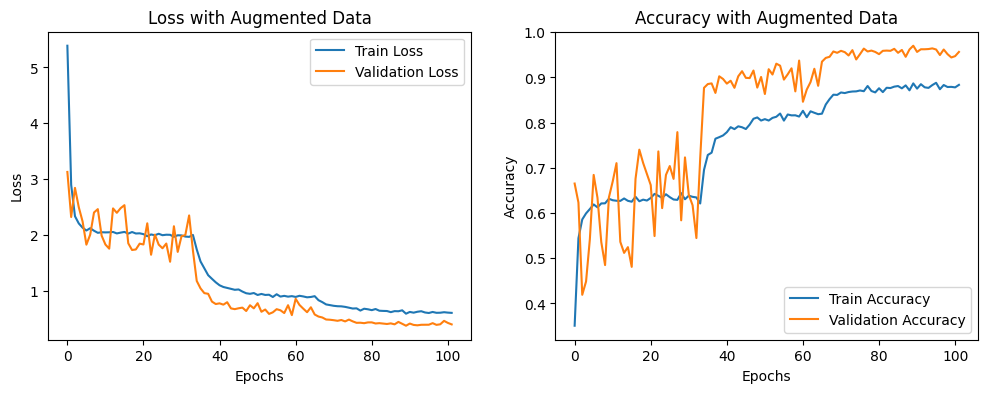

In [50]:
# Embaralhar os dados
df = shuffle(df, random_state=42)

# Preparar os dados para a rede neural
X = np.array(df['question_embeddings'].tolist())
y = to_categorical(df['intention_encoded'])

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Obter os índices para os dados de treinamento
train_indices = df.index[:len(X_train)]

# Criar um DataFrame para os dados de treinamento
df_train = df.loc[train_indices]
df_train_augmented = df_train.copy()

# Aplicar augmentação de dados aos dados de treinamento
df_train_augmented['processed_question'] = df_train_augmented['processed_question'].astype(str).apply(augment_data)
df_train_augmented['question_embeddings'] = df_train_augmented['processed_question'].apply(get_word2vec_embeddings)

# Combinar os dados de treinamento originais e aumentados
df_train_combined = pd.concat([df_train, df_train_augmented])

# Preparar os dados combinados de treinamento para a rede neural
X_train_combined = np.array(df_train_combined['question_embeddings'].tolist())
y_train_combined = to_categorical(df_train_combined['intention_encoded'])

# Construir a rede neural
model = Sequential()
model.add(Input(shape=(X.shape[1],)))

# First Dense layer with Leaky ReLU activation, Batch Normalization, and L2 regularization
model.add(Dense(256, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dropout(0.5))

# Second Dense layer with Leaky ReLU activation, Batch Normalization, and L2 regularization
model.add(Dense(128, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dropout(0.5))

# Third Dense layer with Leaky ReLU activation, Batch Normalization, and L2 regularization
model.add(Dense(64, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(LeakyReLU(negative_slope=0.01))

# Output layer with Softmax activation
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=0.0001)

# Treinar o modelo com os dados aumentados e armazenar o histórico
history_combined = model.fit(X_train_combined, y_train_combined, epochs=250, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Avaliar o modelo com os dados de teste originais
loss_combined, accuracy_combined = model.evaluate(X_test, y_test)
print(f'\nTest Accuracy with Augmented Data: {accuracy_combined}')

# Plotar as métricas de avaliação com os dados aumentados
plt.figure(figsize=(12, 4))

# Plotar a perda com dados aumentados
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['loss'], label='Train Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Loss with Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotar a acurácia com dados aumentados
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['accuracy'], label='Train Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy with Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


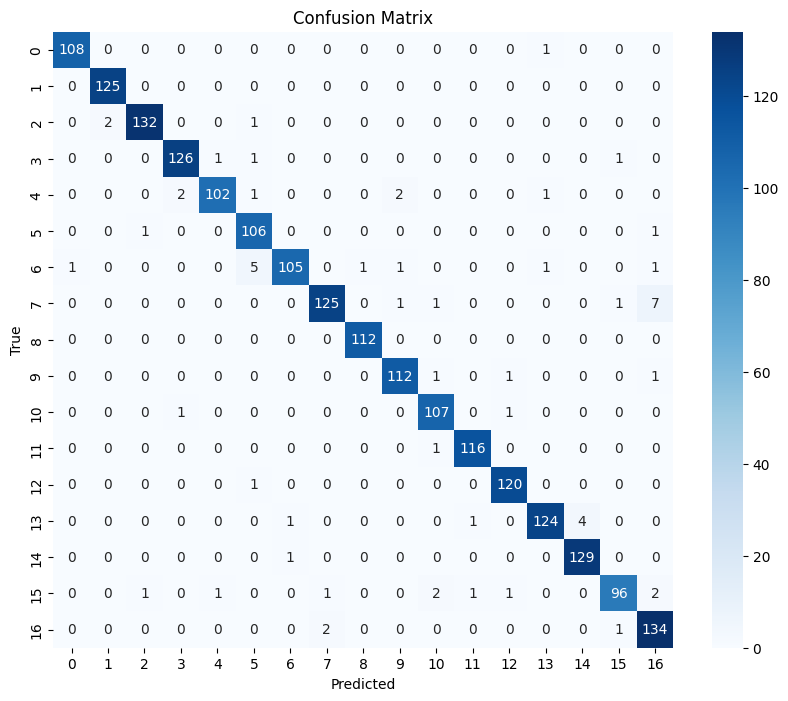

In [69]:
# Predizer as classes no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [71]:
# Predizer as classes no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular as métricas
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

# Criar um DataFrame para as métricas
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Score': [precision, recall, f1]
})

# Exibir as métricas em uma tabela
print(metrics_df)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
      Metric     Score
0  Precision  0.970585
1     Recall  0.970098
2   F1 Score  0.970016


In [74]:
target_names = label_encoder.classes_

# Predizer as classes no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Gerar o relatório de classificação
class_report = classification_report(y_true, y_pred_classes, target_names=target_names)

# Exibir o relatório de classificação
print('Classification Report:')
print(class_report)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
                                    precision    recall  f1-score   support

                    Acesso a conta       0.99      0.99      0.99       109
   Atualizacao de dados cadastrais       0.98      1.00      0.99       125
          Cadastro de beneficiario       0.99      0.98      0.98       135
                      Cancelamento       0.98      0.98      0.98       129
                    Como depositar       0.98      0.94      0.96       108
                Como fazer remessa       0.92      0.98      0.95       108
                 Como se inscrever       0.98      0.91      0.95       115
       Confirmacao de cambio/taxas       0.98      0.93      0.95       135
            Envio via Deposit Code       0.99      1.00      1.00       112
Pedido de envio via metodo ByPhone       0.97      0.97      0.97       115
              Problemas de remessa       0.96      0.98      0.97       109
                         

In [51]:
# Função para prever a intenção
def predict_intention(sentence, word2vec_model, trained_model, label_encoder):
    embedding = word2vec_model.get_sentence_embedding(sentence)
    prediction = trained_model.predict(np.array([embedding]))
    predicted_label = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(predicted_label)[0]

# Pipeline

In [52]:
!pip install jedi
!pip install -U spacy -q
!pip install -U pip setuptools wheel -q
!python -m spacy download pt_core_news_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 104.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [53]:
import os
import re
import nltk
import spacy
import string
import pandas as pd

from copy import Error
from enum import Enum, auto
from spacy.tokens import Token
from google.colab import runtime
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from abc import ABC, abstractmethod
from typing import List, Type, Union
from spacy.tokenizer import Tokenizer
from spacy.lang.xx import MultiLanguage
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from multiprocessing import Pool, cpu_count

In [54]:
nltk.download('rslp')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
class NLPLibrary(Enum):
    """
    Enum for supported NLP libraries.
    """
    nltk = 0
    spacy = 1

class TextProcessingStep(ABC):
    """
    Base class for a text processing step.
    """

    @abstractmethod
    def execute(self, data: Union[str, List[str]]) -> Union[str, List[str]]:
        """
        Executes the processing step.
        """
        pass

    @abstractmethod
    def requires(self) -> List[Type['TextProcessingStep']]:
        """
        Specifies steps that must be executed before this one.
        """
        pass

class PreprocessingTextPipeline:
    """
    Pipeline for managing and executing text preprocessing steps.
    """

    def __init__(self, nlpLibrary: NLPLibrary):
        """
        Initializes the pipeline.
        """
        self.steps = []
        self.nlpLibrary = nlpLibrary

    def add_step(self, step: TextProcessingStep):
        """
        Adds a step to the pipeline, checking dependencies.
        """
        for required_step in step.requires():
            if not any(isinstance(s, required_step) for s in self.steps):
                raise ValueError(f"{step.__class__.__name__} requires {required_step.__name__} to be added first.")

        self.steps.append(step)

    def run(self, data: Union[str, List[str]]) -> Union[str, List[str]]:
        """
        Executes all steps in the pipeline.
        """
        for step in self.steps:
            data = step.execute(data, self.nlpLibrary)
        return data


In [56]:
class RemoveEscapeSequences(TextProcessingStep):
    """
    Removes escape sequences from the text.
    """
    def execute(self, data: str, library: NLPLibrary) -> str:
        return data.translate(str.maketrans({'\n': ' ', '\t': ' ', '\r': ' '}))

    def requires(self) -> List[Type[TextProcessingStep]]:
        return []

class Lowercase(TextProcessingStep):
    """
    Converts all text to lowercase.
    """
    def execute(self, data: str, library: NLPLibrary) -> str:
        return data.lower()

    def requires(self) -> List[Type[TextProcessingStep]]:
        return []

class RemoveNumbers(TextProcessingStep):
    """
    Removes numbers from the text.
    """
    def execute(self, data: str, library: NLPLibrary) -> str:
        return re.sub(r'\d+', '', data)

    def requires(self) -> List[Type[TextProcessingStep]]:
        return []

class RemovePunctuation(TextProcessingStep):
    """
    Removes punctuation from the text.
    """
    def execute(self, data: str, library: NLPLibrary) -> str:
        translator = str.maketrans('', '', string.punctuation)
        return data.translate(translator)

    def requires(self) -> List[Type[TextProcessingStep]]:
        return []

class Tokenization(TextProcessingStep):
    """
    Tokenizes the text into words.
    """
    def execute(self, data: str, library: NLPLibrary) -> List[str]:
        if library == NLPLibrary.nltk:
            return word_tokenize(data)
        elif library == NLPLibrary.spacy:
            tokens = MultiLanguage().tokenizer(data)
            return [token.text for token in tokens]

    def requires(self) -> List[Type[TextProcessingStep]]:
        return []

class RemoveStopwords(TextProcessingStep):
    """
    Removes stopwords from the text.
    """
    def execute(self, data: List[str], library: NLPLibrary) -> List[str]:
        if library == NLPLibrary.nltk:
            stop_words = set(stopwords.words('portuguese'))
            return [word for word in data if word.lower() not in stop_words]
        elif library == NLPLibrary.spacy:
            nlp = spacy.load("pt_core_news_sm")
            doc = nlp.make_doc(" ".join(data))
            return [token.text for token in doc if not token.is_stop]

    def requires(self) -> List[Type[TextProcessingStep]]:
        return [Tokenization]

class Stemming(TextProcessingStep):
    """
    Applies stemming to the text.
    """
    def execute(self, data: List[str], library: NLPLibrary) -> List[str]:
        if library == NLPLibrary.nltk:
            stemmer = RSLPStemmer()
            return [stemmer.stem(word) for word in data]
        elif library == NLPLibrary.spacy:
            raise Error("spacy does not provide built-in stemming resources")

    def requires(self) -> List[Type[TextProcessingStep]]:
        return [Tokenization, RemoveStopwords]

class Lemmatization(TextProcessingStep):
    """
    Applies lemmatization to the text.
    """
    def execute(self, data: List[str], library: NLPLibrary) -> List[str]:
        if library == NLPLibrary.nltk:
            raise Error("nltk does not provide built-in pt-br lemmatizer resources")
        elif library == NLPLibrary.spacy:
            nlp = spacy.load("pt_core_news_sm")
            doc = nlp(" ".join(data))
            return [token.lemma_ for token in doc]

    def requires(self) -> List[Type[TextProcessingStep]]:
        return [Tokenization, RemoveStopwords]

In [57]:
# Build the sequence that belongs to Pipeline
pipeline = PreprocessingTextPipeline(NLPLibrary.spacy)

pipeline.add_step(RemoveEscapeSequences())
pipeline.add_step(Lowercase())
pipeline.add_step(RemoveNumbers())
pipeline.add_step(RemovePunctuation())
pipeline.add_step(Tokenization())

In [58]:
def process_question(question):
    # Process a question using the NLP pipeline and join the results with commas.
    return ','.join(pipeline.run(question))

# Exemplos

In [59]:
sentence = process_question("quanto dá 1000 yenes hoje?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Predicted Intention: Confirmacao de cambio/taxas


In [60]:
sentence = process_question("Se eu depositar 1000 reais hoje quanto preciso pagar em yenes?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Intention: Confirmacao de cambio/taxas


In [61]:
sentence = process_question("Esqueci minha senha. O que eu faço para acessar minha conta agora?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Intention: Acesso a conta


In [62]:
sentence = process_question("Esqueci minha senha.")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Intention: Acesso a conta


In [63]:
sentence = process_question("Quanto tempo até receber minha remessa no Brasil? Demora muito?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Intention: Tempo de remessa


In [64]:
sentence = process_question("Quero cancelar uma remessa. Como faço?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Intention: Cancelamento


In [65]:
sentence = process_question("Minha remessa ainda não caiu. O que houve?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Intention: Problemas de remessa


In [ ]:
sentence = process_question("Como faço uma remessa do Japão?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Intention: Como fazer remessa


In [66]:
sentence = process_question("Não consigo entrar na minha conta")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Intention: Acesso a conta


In [79]:
sentence = process_question("Como eu envio?")
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Intention: Como fazer remessa
